In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import functional as F
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import random

import requests
from io import BytesIO

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        self.middle = DoubleConv(512, 1024)
        
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(1024, 512)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(512, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(256, 128)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.pool1(x1)
        
        x3 = self.down2(x2)
        x4 = self.pool2(x3)
        
        x5 = self.down3(x4)
        x6 = self.pool3(x5)
        
        x7 = self.down4(x6)
        x8 = self.pool4(x7)
        
        x9 = self.middle(x8)
        
        x = self.up4(x9)
        x = torch.cat([x7, x], dim=1)
        x = self.up_conv4(x)
        
        x = self.up3(x)
        x = torch.cat([x5, x], dim=1)
        x = self.up_conv3(x)
        
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.up_conv2(x)
        
        x = self.up1(x)
        x = torch.cat([x1, x], dim=1)
        x = self.up_conv1(x)
        
        x = self.final_conv(x)
        return x

In [3]:
model = UNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load('/kaggle/input/bird-image-semantic-segmentation/unet_model.pth', map_location=torch.device('cpu')))

/tmp/ipykernel_24/1283031411.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/bird-image-semantic-segmentation/unet_model.

<All keys matched successfully>

In [4]:
def preprocess_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(img).unsqueeze(0), img

def visualize_results(original_img, mask, pred):
    mask = mask.cpu().numpy()
    pred = pred.cpu().numpy()

    pred_binary = (pred >= 0.8).astype(int)
    pred_3d = np.stack([pred_binary, pred_binary, pred_binary], axis=-1)

    pred_resized = np.array(Image.fromarray((pred * 255).astype(np.uint8)).resize(original_img.size)) / 255.0
    pred_3d = np.stack([pred_resized, pred_resized, pred_resized], axis=-1)
    
    seg_img = np.asarray(original_img) / 255.0 * pred_3d

    fig, ax = plt.subplots(1, 3, figsize=(16, 12))
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(pred_resized, cmap='gray')
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')

    ax[2].imshow(seg_img)
    ax[2].set_title('Segmented Image')
    ax[2].axis('off')

    plt.show()

def perform_inference(url):
    input_tensor, original_img = preprocess_image_from_url(url)
    input_tensor = input_tensor

    with torch.no_grad():
        output = model(input_tensor)
        output = torch.sigmoid(output).squeeze(0).squeeze(0)

    visualize_results(original_img, output, output)

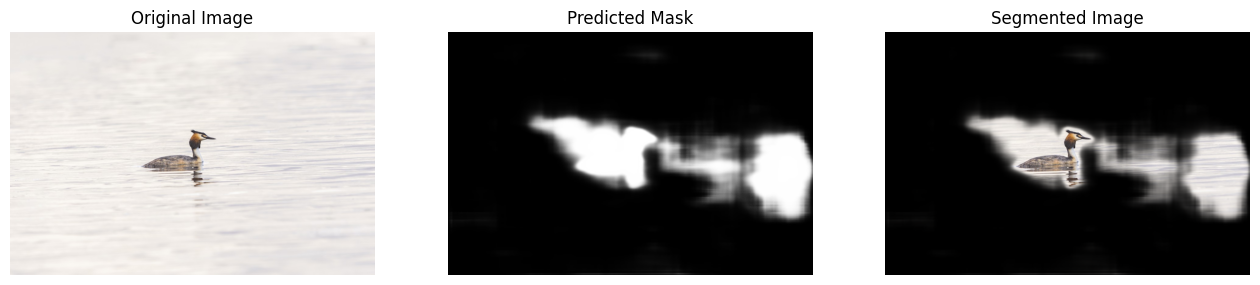

In [5]:
image_url = 'https://cdn.download.ams.birds.cornell.edu/api/v2/asset/626458369/1200'
perform_inference(image_url)

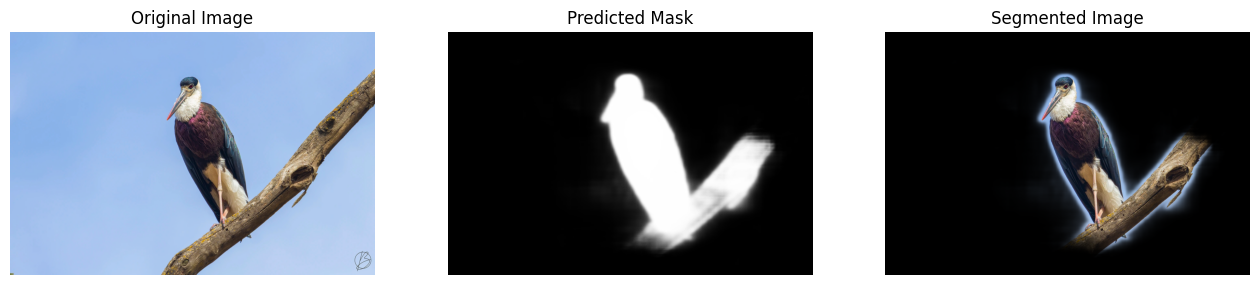

In [6]:
image_url = 'https://birdingwitharjun.com/wp-content/uploads/2023/04/img_8833-2.webp'
perform_inference(image_url)

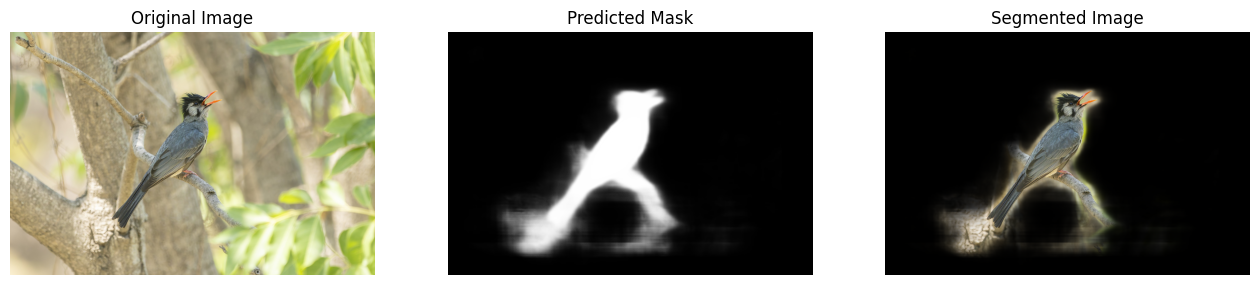

In [7]:
image_url = 'https://cdn.download.ams.birds.cornell.edu/api/v2/asset/626744857/2400'
perform_inference(image_url)

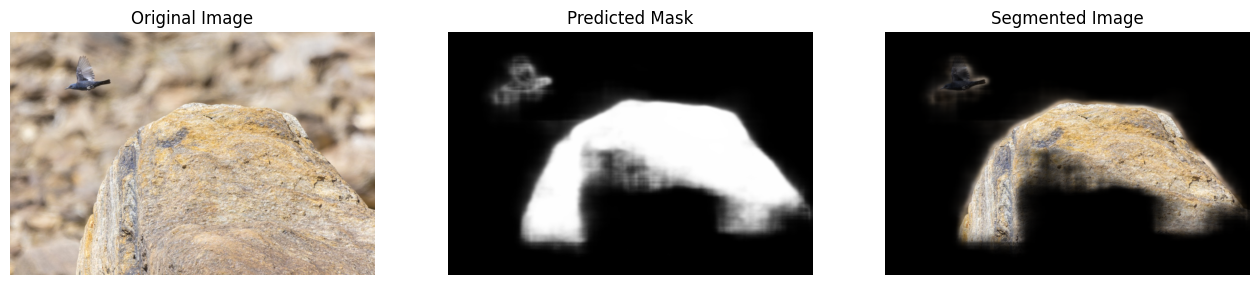

In [8]:
image_url = 'https://cdn.download.ams.birds.cornell.edu/api/v2/asset/626566301/1200'
perform_inference(image_url)